# Useful libraries for scientific computing

One of the strongest points of Python is the flourishing *ecosystem* of libraries it 
comes with. We have already seen some of them, such as [`numpy`](numpy.md) and
 [`matplotlib`](plotting.md). This chapter reviews other libraries that are handy 
to code scientific computing applications, including computational chemistry ones.
We will mostly focus on `scipy`, highlighting some of its submodules that provide 
a huge set of numerical algorithms, and also briefly mention other projects that
 you will likely find useful.
The classification of these libraries as integral components of Python's core or
 specialized tools might provoke debate, yet you'll undoubtedly benefit from
 the diverse array of supplementary features accessible across various layers. 
![ecosystem](https://jupytearth.org/_images/python-stack.png)

## `scipy` 

This module contains a collection of numerical algorithms such as integration,
optimization, interpolation, linear algebra, statistics, and much more.
It is built on top of `numpy`, i.e., it mainly uses numpy arrays as the main
data structure.

`scipy` is organized in submodules, each one with a specific purpose, which can be imported separately as,

```python
import scipy.submodulename
#or
from scipy import submodulename
```

The submodules that normally fulfill the needs of a computational chemist are:

- `integrate`: Integration and ordinary differential equation solvers
- `interpolate`: Interpolation and smoothing splines
- `optimize`: Optimization and root-finding routines
- `linalg`: Linear algebra, which actually provides an interface to BLAS and LAPACK libraries.
Note that it generally supports all `numpy.linalg` functions, and `scipy.linalg` versions are preferred.

In this chapter we will focus on the first three submodules. The list of submodules is more extensive,
including `fft` (Fast Fourier Transform), `special` (special functions, such as Hermite polynomials). 
A complete list can be found in the [official documentation](https://docs.scipy.org/doc/scipy/reference/).

### `scipy.integrate`

This submodule provides several integration routines, including an ordinary 
differential equation integrator.

**Integration** of a 1D function, can be done with the `quad` method. It takes a function
and the integration limits as arguments, and returns the integral and an estimate of the error.
Let's see an example:

In [1]:
from scipy.integrate import quad
import numpy as np

def gaussian(x, mu, sigma):
    return 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-(x-mu)**2/(2*sigma**2))

mu = 0
sigma = 1
norm, err = quad(gaussian, -np.inf, np.inf, args=(mu, sigma))
print(norm)

0.9999999999999997


Other methods to integrated 1D functions are `fixed_quad`, `quadrature` or `romberg`.

Instead, integration of a discrete function (1D), i.e., a set of points,
can be done with the `trapz`, `romb` and `simps` functions. In the case, the
functions take as arguments the `x` and `y` arrays with the grid and function values, 
and return the integral.
For instance,

In [2]:
from scipy.integrate import simps
import numpy as np

def gaussian(x, mu, sigma):
    return 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-(x-mu)**2/(2*sigma**2))

x = np.linspace(-100, 100, 5000)
mu = 0
sigma = 1
y = gaussian(x, mu, sigma)
print(simps(y, x=x))

1.0000000000000002


```{exercise}
:nonumber:
:class: dropdown

Write a program to check the orthogonality of the vibrational eigenfunctions of the
harmonic oscillator.

*Hint*: The eigenfunctions of the harmonic oscillator can be written as:

$$
\psi_n(Q) = 
\frac{1}{\sqrt{2^n n!}} 
\left(\frac{\omega}{\pi\hbar}\right)^{1/4} 
e^{-\omega Q^2/2\hbar} 
H_n\left(\sqrt{\frac{\omega}{\hbar}}Q\right)
$$
where $H_n$ are the Hermite polynomials, which can be evaluated with the function
`scipy.special.eval_hermite`.

```

Functions for multidimensional integration are also available, such as `dblquad` (double integral),
`tplquad` (triple integral) and `nquad` (integration over multiple variables).

This submodule also provides methods to integrate **ordinary differential equations**. 
The recommended method is `solve_ivp` (solve initial value problem),
which gives an interface to different integration algorithms.
For instance, in order to integrate the system of differential equations below,

$$
\begin{align}
\frac{dx}{dt} &= -y \\
\frac{dy}{dt} &= x
\end{align}
$$
we can use the following code,

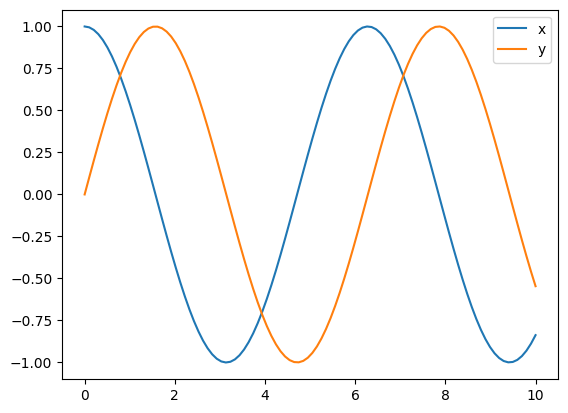

In [3]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt

def f(t, y):
    return [-y[1], y[0]]
    
t0 = 0
tf = 10
y0 = [1, 0]
t_eval = np.linspace(t0, tf, 100)
sol = solve_ivp(f, [t0, tf], y0, t_eval=t_eval)

plt.plot(sol.t, sol.y[0], label='x')
plt.plot(sol.t, sol.y[1], label='y')
plt.legend()
plt.show()

The integration algorithm is set with the `method` attribute, with the default 
being `RK45` (Runge-Kutta of 4th order).

### `scipy.interpolate`

This submodule provides several interpolation routines. In the case of 1D interpolation, i.e.
from a discrete set of $(x,y)$ points, the most common method is `interp1d`. This function takes
as arguments the `x` and `y` arrays, and returns a function object that can be evaluated at any point,
within the range of `x` (values out of this range can be managed with the `fill_value` argument).
For instance,

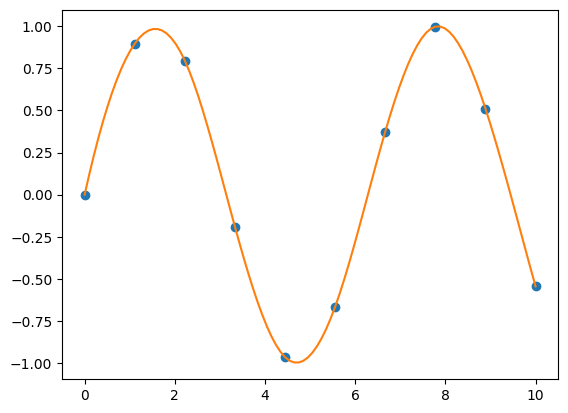

In [4]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 10, 10)
y = np.sin(x)
f = interp1d(x, y, kind='cubic')

xnew = np.linspace(0, 10, 100)
ynew = f(xnew)

plt.plot(x, y, 'o', xnew, ynew, '-')
plt.show()

As shown in the above example, the `kind` argument specifies the type of interpolation. Possible
values include `linear` (which is the default), `quadratic` or `cubic` (a complete list
can be found in the [official documentation](https://docs.scipy.org/doc/scipy/reference/interpolate.html)).

```{exercise}
:nonumber:
:class: dropdown

Write a program that sums two spectra defined over different 
wavelength ranges. Use interpolation to generate a common wavelength
grid, and then sum the spectra.

*Note*: spectra to test your code can be obtained from 
[PhotochemCAD](http://omlc.org/spectra/PhotochemCAD).
You can use the `requests` module to download the files:

```python
import requests

# Azobenzene
URL = "https://omlc.org/spectra/PhotochemCAD/data/117-abs.txt"
response = requests.get(URL)
open("spc1.dat", "w").write(response.content)

# 9,10-Diphenylanthracene
URL = "https://omlc.org/spectra/PhotochemCAD/data/021-abs.txt"
response = requests.get(URL)
open("spc2.dat", "w").write(response.content)

```

For 2D interpolation, the most general function is `interp2d`. This function takes as arguments
a 2D array of values, `Z`, and the two 1D arrays of coordinates, `x` and `y`. These arrays
do not have to be equally spaced. As in the 1D case, it returns a function that can be evaluated 
at any point.

/tmp/ipykernel_2586/1111923138.py:10: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  f = interp2d(x, y, Z, kind='cubic')
/tmp/ipykernel_2586/1111923138.py:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGr

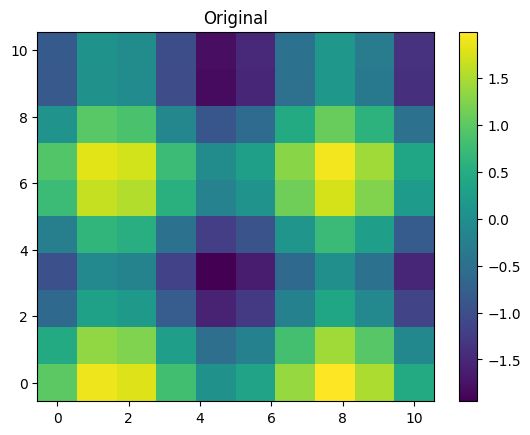

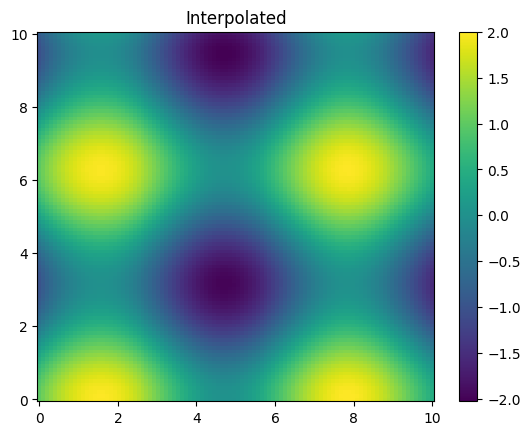

In [5]:
from scipy.interpolate import interp2d
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 10, 10)
y = np.linspace(0, 10, 10)
X, Y = np.meshgrid(x, y)
Z = np.sin(X) + np.cos(Y)

f = interp2d(x, y, Z, kind='cubic')

xnew = np.linspace(0, 10, 100)
ynew = np.linspace(0, 10, 100)
znew = f(xnew, ynew)

plt.pcolormesh(X, Y, Z)
plt.colorbar()
plt.title('Original')
plt.show()
plt.pcolormesh(xnew, ynew, znew)
plt.colorbar()
plt.title('Interpolated')
plt.show()

As you can see, we use some kind of *advanced* `matplotlib` features in this example. 
You can refresh them going back to the [previous chapter](plotting.md).
For instance, use the `np.meshgrid` function, which generates 2D arrays with 
the grid points, (`x`,`y`), from the corresponding 1D arrays, `x` and `y`. The interpolation 
method is specified with the `kind` argument, which can take the same values as in the 1D case.

The above example uses a regular grid, but this is not a requirement. Actually, in this case
we can use the function `RectBivariateSpline`, which is more efficient but is restricted to
regular grids. This function takes the same arguments as `interp2d`.

To interpolate unstructured data we can use the function `griddata`. 
It takes as arguments the coordinates of the data points as a tuple of 1D arrays,
`(x,y)` and the values at these points, `z`, also a 1D array. 
It also takes the coordinates of the points where the interpolation is required, `(Xi,Yi)`. 
In this case, it returns the interpolated values at these points as a 2D array `Zi`.
The interpolation method is specified with the `method` argument. Possible values are `linear`,
`nearest` and `cubic`.

### `scipy.optimize`

This module provides several algorithms for optimization (locating minima and maxima) and 
root-finding.

The function `minimize` provides a common interface to all the **optimization** algorithms.
It takes as arguments the function to be minimized, `f(x)`, the initial guess, `x0`, and
the method to be used, `method`. The function to be minimized must take as argument a 1D array
with the values of the variables to be optimized, and return a scalar. For instance,

In [6]:
from scipy.optimize import minimize
import numpy as np

def f(x):
    return np.sum(x**2)
    
x0 = np.array([1, 2, 3])
res = minimize(f, x0, method='Nelder-Mead')
print(res.x)

[-4.80659631e-05 -1.10944154e-05 -1.86599703e-05]


As shown above, the `minimize` function returns an object with the results of the optimization.
The `x` attribute contains the values of the variables that minimize the function. Other 
attributes of the result object are `fun`, which contains the value of the function at the
minimum, `success`, which is a boolean indicating if the optimization was successful, or the
number of iterations, `nit`, among others.

Different optimization algorithms can be used with the `method` argument, including `BFGS` (default
for unconstrained problems) or `Newton-CG`. The choice of the method
depends on the problem (stiffness, dimensionality, etc.), and the need of adding constraints
A complete list is given in the 
[documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize).

For **root-finding** of scalar functions (univariate functions, i.e., which depend on only 
one variable), we can use the general interface function `root_scalar`.
It takes as arguments the function to be solved, `f(x)` and some other arguments depending
on the method to be used, `method`. For instance, with `method=bisect`, we need to provide
the closed interval where the solution lies, `bracket`. Other methods may require the
derivative of the function, `fprime` and/or an initial guess, `x0`.
The function to be solved must take as argument a scalar
and return a scalar. For instance,

In [7]:
from scipy.optimize import root_scalar
import numpy as np

def f(x):
    return np.exp(x) + x
    
res = root_scalar(f, bracket=[-2.0,2.0], method='bisect')
print(res.root)

-0.5671432904109679


Again, the `root_scalar` function returns an object with the results of the root-finding.
The `root` attribute contains the value of the variable that solves the equation.

The function `root` provides a common interface to all the root-finding algorithms
for vector functions (i.e, a system of `N` equations that depend on `N` variables).
It takes as arguments the function to be solved, `f(x)`, which depends on a 1D array (vector) 
of `N` variables, `x`, the initial guess, `x0`, and
the method to be used, `method`. The function to be solved must take as argument a 1D array
with the values of the variables to be solved, and returns a 1D array with the same shape.
For instance, the following system of equations:

$$
\begin{align}
x^2 + y^2 = 1 \\
x - y = 0
\end{align}
$$
can be solved as follows:

In [8]:
from scipy.optimize import root
import numpy as np

def f(x):
    return np.array([x[0]**2 + x[1]**2 - 1, x[0] - x[1]])

x0 = np.array([1, 2])
res = root(f, x0, method='hybr')
print(res.x)

[0.70710678 0.70710678]


Available methods are summarized in the [documentation](https://docs.scipy.org/doc/scipy/reference/optimize.html#root-finding)
of this function.

## `sympy`

This module is a computer algebra system (CAS), similar to [Maxima](https://maxima.sourceforge.io) 
or Mathematica. It allows performing symbolic calculations, such as derivatives, integrals,
solving equations, etc.

We will not go into details here, but we will show some examples of the capabilities of this
module. For instance, lets compute the derivative of the function $f(x) = \sin(x) \cos(x)$:

In [9]:
from sympy import symbols, sin, cos, diff

x = symbols('x')
f = sin(x)*cos(x)
df = diff(f, x)
df

-sin(x)**2 + cos(x)**2

Many other symbolic operations are possible, such as integrals, limits, series expansions, etc.
Check the [documentation](https://docs.sympy.org/latest/index.html) for more details.

(pandas)=
## `pandas`

This module provides high-performance, easy-to-use data structures and data analysis tools, allowing 
to manipulate and analyze large amounts of data. You can read and write data sets from file formats such 
as csv, excel, hdf5, etc. For instance, to read a csv file:

```python
import pandas as pd

# Read a csv file
df = pd.read_csv('file.csv')
# Get the values of column labelled 'Col1' as a numpy array
x = df['Col1'].values
```

You can check the [documentation](https://pandas.pydata.org/docs/)
for more details.

(ase)=
## `ase`

ASE stands for Atomic Simulation Environment. 
This module provides a set of tools for setting up, manipulating, running,
visualizing and analyzing atomistic simulations. It supports many
codes through the `Calculator` interface, e.g. Gaussian or Gromacs, 
allowing to perform a wide range of calculations from a single Python script.

It also provides functions to read and write files in different formats (xyz, pdb...), 
through the `ase.io` submodule. For instance, to read a file in xyz format:

```python
# The io submodule must be imported separately
import ase.io

# Generate an ASE Atom object from a file
molec = ase.io.read('file.xyz')
# Get the atomic coordinates as a numpy array:
xyz = molec.get_positions()
```

You can take a further look into the powerful capabilities of this library in the
[documentation](https://wiki.fysik.dtu.dk/ase/).

## `h5py`

This module provides support to manipulate [HDF5](https://en.wikipedia.org/wiki/HDF5) files, 
a format specifically designed to store large amounts of numerical data. 
There are other formats that are also very useful for this purpose, such as
[netCDF](https://www.unidata.ucar.edu/software/netcdf/),
[JSON](https://en.wikipedia.org/wiki/JSON) or
[XML](https://en.wikipedia.org/wiki/XML), which are also supported by Python modules.